## Global Horizontal Irradiance

Compute the Global Horizontal Irradiance of a defined region based on its latitude and longitude an universal time zone

In [1]:
# Module to use 
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Symplify the call for the function that converts from degree/radians to radians/degree
d2r = np.deg2rad
r2d = np.rad2deg

## Declination angle

The different formula used in the following cell can be found here [here](https://www.pveducation.org/pvcdrom/properties-of-sunlight/declination-angle). They are based on [PCo1969](https://www.sciencedirect.com/science/article/pii/0038092X69900474) and [MBlCDi2001](https://www.sciencedirect.com/science/article/pii/S0038092X00001560).


In [3]:
# Change these three lines according to the region one wish to compute the GHI for 
# Region considered: NewYork
ϕ  = 40.72                                    # Latitude of location of interest
longi = -74.005974                            # Longitude in degrees of location of interest
ΔT_utc = - 5                                  # Time zone of location of interest



days = np.arange(1,366)                       # TOtal number of days in a year 
δ = - 23.45 * np.cos(d2r(360/365*(days+10)))  # Declination angle in degree 
α_noon = 90 + ϕ - δ                           # Elevation angle at solar Noon 
α_noon = 180 - α_noon                           # In this case α > 90 ==> Northen hemisphere, sun 
                                              # is coming from the south so substract result from 180°

### Plot

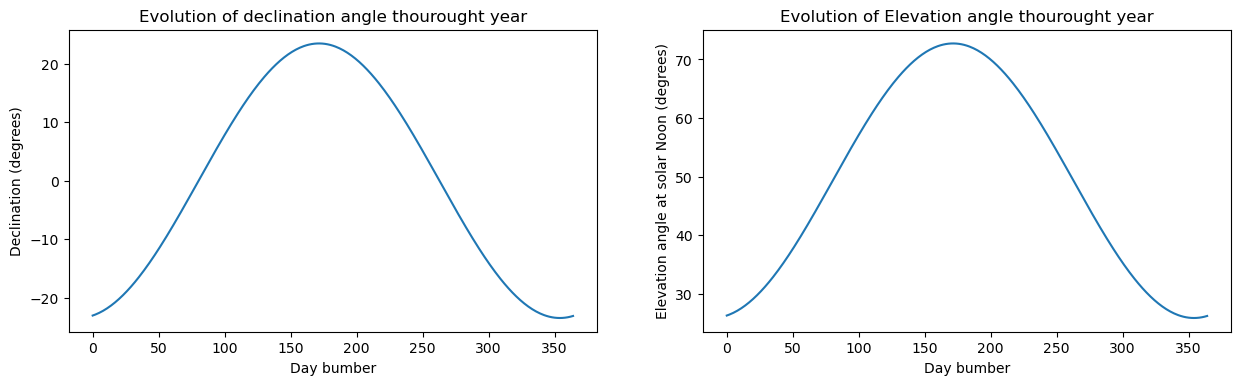

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,4), dpi=100)
ax[0].plot(δ);
ax[0].set(xlabel='Day bumber', ylabel='Declination (degrees)',
          title='Evolution of declination angle thourought year')
ax[1].plot(α_noon)
ax[1].set(xlabel='Day bumber', ylabel='Elevation angle at solar Noon (degrees)', 
          title='Evolution of Elevation angle thourought year');


## Global Solar irradiance (or Global Horizontal Irradiance)


The different formula (i.e. LSTM, EoT, TC, LST, HRA) used in the following cell can be found [here](https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-time#HRA). They are based on [RMi1921](https://www.cambridge.org/core/journals/mathematical-gazette/article/abs/593-note-on-the-equation-of-time/D92D1194399A91EECD85B9F93C0DEEA1) and [ZEv1982](https://www.journals.uchicago.edu/doi/10.1086/227631). The GHI is based on [RSc1976](https://www.sciencedirect.com/science/article/pii/0002157176900704), [FanRUr2019](https://www.sciencedirect.com/science/article/abs/pii/S1364032119301261) and [wiki](https://en.wikipedia.org/wiki/Solar_zenith_angle)

In [5]:
# Compute the GHI for the whole year 2019 
GHI_list = []                           # List to store the daily GHI 
freq_mn = 5                             # frequency of the GHI 5 mn. Can be changed to acclimate for the problem
total_diy = 365                         # Total day in the year
LSTM = 15*ΔT_utc                        # 15 = 360°/24hours Local standard time meridian 
B = 360/365*(days-81)                  
EoT = ( 9.87*np.sin(d2r(2*B)) - 
       7.53*np.cos(d2r(B)) -
       1.5*np.sin(d2r(B)) )             # Equation of time (EoT) depends on day of year 


for doy in range(1,total_diy+1) :       # for each day of the year
    
    TC = 4* (longi - LSTM) + EoT[doy-1] # Time correction factor:  Earth rotates 1° every 4 minutes.
    LT = np.arange(0,1440,freq_mn)/60   # in freq of 5mn converted in hour.

    LST = LT + TC/60                    # Local Solar time
    HRA = 15*(LST-12)                   # Hour angle variation throughout a day 

    # The solar zenith angle is θ while the solar elevation/altitude angle is given by α = 90-θ
    int_var = np.sin(d2r(δ[doy-1]))*np.sin(d2r(ϕ)) + np.cos(d2r(δ[doy-1]))*np.cos(d2r(ϕ))*np.cos(d2r(HRA))
    
    # np.arcsin(int_var ) = np.arccos(int_var)  
    cos_θ = int_var                     #  Note:  cos_θ = sin_α since α = 90-θ 
    cos_θ[cos_θ<0] =  0                 #  If cos < 0 ==> Night time. Those values are not needed
    
    GHI = 951.3*cos_θ**1.15;
    
    GHI_list.append(GHI)
    
year_GHI = np.array(GHI_list).reshape((-1)) # Transform list on one dimension array 

# Create dataFrame based on previous array 
GHI_df = pd.DataFrame(data=year_GHI, 
                      index=pd.date_range('01 01 2019','31 12 2019 23:55', freq=f'{freq_mn}T'),
                      columns=['Clearsky GHI'],)

### Plot Yearly ClearSky GHI

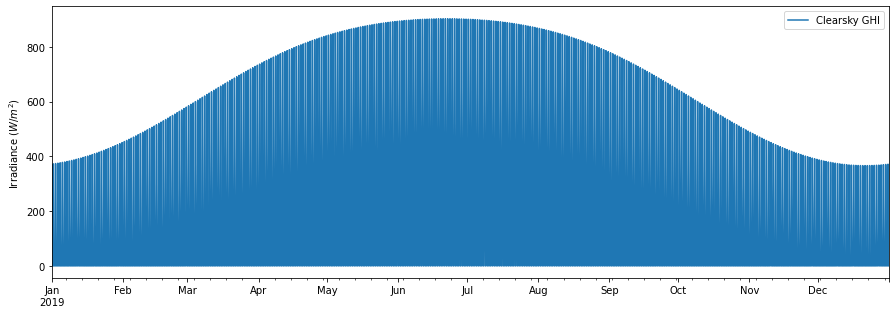

In [6]:
GHI_df.plot(figsize=(15,5),)
plt.ylabel('Irradiance ($W/m^{2}$)');
# plt.xlim(['01 01 2019','01 02 2019'])

### Plot Daily ClearSky GHI for some random day of the year

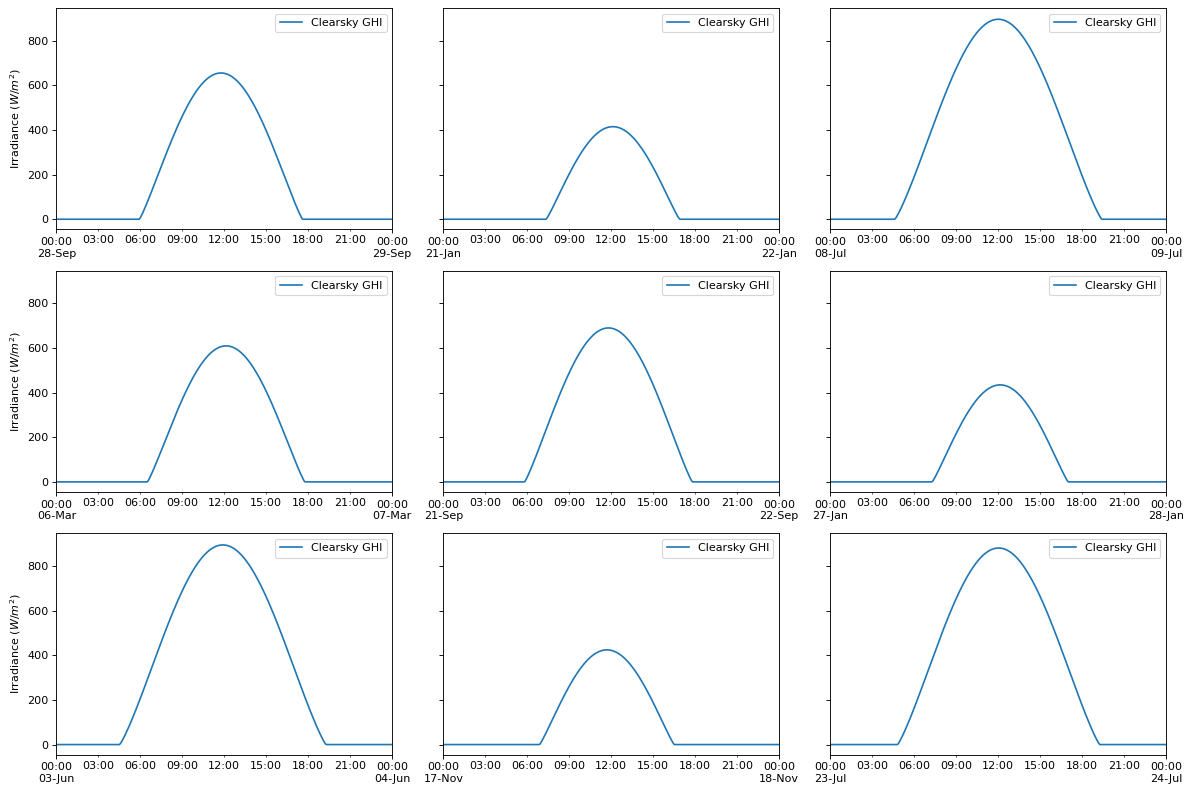

In [9]:
months = range(1,13) # Number of months in a year
days = range(1,30)   # Number of days in a month  

n_rows = 3           # Nummber of row for plot
n_cols = 3           # Nummber of columns for plot

# Choose randomly n_rows*n_cols months and days 
rand_month = np.random.choice(months, size = n_rows*n_cols)
rand_day = np.random.choice(days, size = n_rows*n_cols)


if (rand_month == 2).sum() > 0: # If February is among the randomly selected months 
    
    # If the day associated day to february is above the total 
    #  number  of day in February choose a new day 
    while rand_day[rand_month == 2] > 28: 
        rand_day[rand_month==2] = np.random.choice(days,)

fig, axis = plt.subplots(n_rows,n_cols, figsize=(15,10), dpi=80, sharey=True)

for axx, month_day_index in zip(axis.flatten(), range(n_rows*n_cols)):
    GHI_df.plot(xlim = [f'{rand_month[month_day_index]} {rand_day[month_day_index]} 2019',
                        f'{rand_month[month_day_index]} {rand_day[month_day_index]+1} 2019'], 
                ax = axx,
                ylabel = 'Irradiance ($W/m^{2}$)')

    
fig.tight_layout()